### File handling 

In [2]:
pip install colorama openpyxl matplotlib

Note: you may need to restart the kernel to use updated packages.


#### File and imports

In [3]:
import os
import csv
from datetime import datetime, date
from collections import Counter
from itertools import accumulate

from colorama import Fore, init
from openpyxl import Workbook
import matplotlib.pyplot as plt

init(autoreset=True) # colorama init

FILENAME = "tasks.csv"
FIELDNAMES = ["Title", "Category", "Deadline", "Priority", "Status"]

#### File Initialization

In [4]:
def ensure_file():
    if not os.path.exists(FILENAME):
        with open(FILENAME, "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=FIELDNAMES)
            writer.writeheader() 

#### Reading and Writing Data

In [5]:
def read_tasks():
    ensure_file()
    tasks = []
    with open(FILENAME, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            tasks.append({k: (row.get(k) or "").strip() for k in FIELDNAMES})
    return tasks

def write_tasks(tasks):
    with open(FILENAME, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=FIELDNAMES)
        writer.writeheader()
        for t in tasks:
            writer.writerow(t)

### Adding New Tasks

In [6]:
def add_task():
    title = input("Enter task title: ").strip()
    if not title:
        print(Fore.RED + "Title cannot be empty.")
        return
    category = input("Enter category (Work/Personal/Study etc.): ").strip()
    deadline = input("Enter deadline (YYYY-MM-DD): ").strip()
    priority = input("Enter priority (High/Medium/Low): ").strip().title() or "Low"

    try:
        datetime.strptime(deadline, "%Y-%m-%d")
    except ValueError:
        print(Fore.RED + " Invalid date format. Use YYYY-MM-DD.")
        return

    task = {
        "Title": title,
        "Category": category,
        "Deadline": deadline,
        "Priority": priority,
        "Status": "PENDING"
    }

    ensure_file()
    with open(FILENAME, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=FIELDNAMES)
        writer.writerow(task)

    print(Fore.GREEN + " Task added.\n")


### Viewing Tasks

In [7]:
def view_tasks():
    tasks = read_tasks()
    if not tasks:
        print(Fore.RED + "No tasks found.\n")
        return

    def key_deadline(t):
        try:
            return datetime.strptime(t["Deadline"], "%Y-%m-%d").date()
        except Exception:
            return date.max

    tasks_sorted = sorted(tasks, key=key_deadline)
    today = date.today()

    print("\n--- Your To-Do List ---")
    for i, t in enumerate(tasks_sorted, start=1):
        try:
            d = datetime.strptime(t["Deadline"], "%Y-%m-%d").date()
        except Exception:
            d = None

        st = t["Status"].upper()
        if st == "DONE":
            status_text = Fore.GREEN + "DONE"
        elif d and d < today:
            status_text = Fore.RED + "OVERDUE"
        else:
            status_text = Fore.YELLOW + t["Status"]

        p = t["Priority"].lower()
        if p == "high":
            priority_text = Fore.RED + t["Priority"]
        elif p == "medium":
            priority_text = Fore.YELLOW + t["Priority"]
        else:
            priority_text = Fore.CYAN + t["Priority"]

        print(f"{i}. {t['Title']} | {t['Category']} | Deadline: {t['Deadline']} | "
              f"Priority: {priority_text} | Status: {status_text}")
    print()



### Searching by Category

In [8]:
def search_by_category():
    cat = input("Enter category to search: ").strip().lower()
    if not cat:
        print(Fore.RED + "Category cannot be empty.\n")
        return
    tasks = read_tasks()
    found = [t for t in tasks if t["Category"].strip().lower() == cat]
    if not found:
        print(Fore.RED + f"No tasks found in category '{cat}'.\n")
        return

    print(f"\n--- Tasks in category '{cat}' ---")
    for t in found:
        print(f"- {t['Title']} | {t['Deadline']} | {t['Priority']} | {t['Status']}")
    print()

### updating tasks

In [9]:
def mark_done():
    tasks = read_tasks()
    if not tasks:
        print(Fore.RED + "No tasks found.\n")
        return

    def key_deadline(t):
        try:
            return datetime.strptime(t["Deadline"], "%Y-%m-%d").date()
        except Exception:
            return date.max

    tasks_sorted = sorted(tasks, key=key_deadline)
    print("\nSelect task to mark as DONE:")
    for i, t in enumerate(tasks_sorted, start=1):
        print(f"{i}. {t['Title']} | {t['Deadline']} | {t['Status']}")

    choice = input("Enter task number: ").strip()
    if not choice.isdigit():
        print(Fore.RED + "Invalid input.\n")
        return
    idx = int(choice) - 1
    if idx < 0 or idx >= len(tasks_sorted):
        print(Fore.RED + "Invalid task number.\n")
        return

    tasks_sorted[idx]["Status"] = "DONE"
    write_tasks(tasks_sorted)
    print(Fore.GREEN + " Task marked as DONE.\n")

### Exporting to Excel

In [10]:
def export_to_excel():
    tasks = read_tasks()
    if not tasks:
        print(Fore.RED + "No tasks found to export.\n")
        return

    wb = Workbook()
    ws = wb.active
    ws.title = "To-Do List"
    ws.append(FIELDNAMES)
    for t in tasks:
        ws.append([t[f] for f in FIELDNAMES])

    out = "tasks.xlsx"
    wb.save(out)
    print(Fore.GREEN + f" Exported to {out}\n")

### Visualizing tasks

In [11]:
def visualize_tasks():
    tasks = read_tasks()
    if not tasks:
        print(Fore.RED + "No tasks found for visualization.\n")
        return

    today = date.today()
    status_counter = Counter()
    category_counter = Counter()
    deadline_counter = Counter()

    for t in tasks:
        try:
            d = datetime.strptime(t["Deadline"], "%Y-%m-%d").date()
        except Exception:
            d = None

        if t["Status"].upper() == "DONE":
            status_counter["DONE"] += 1
        elif d and d < today:
            status_counter["OVERDUE"] += 1
        else:
            status_counter["PENDING"] += 1

        category_counter[t["Category"]] += 1
        if d:
            deadline_counter[d.isoformat()] += 1

    # Pie chart
    labels = list(status_counter.keys())
    sizes = [status_counter[k] for k in labels]
    if sum(sizes) > 0:
        plt.figure(figsize=(6,6))
        plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
        plt.title("Task Status Distribution")
        plt.show()
    else:
        print("No status data to plot.\n")

    # Bar chart
    if category_counter:
        plt.figure(figsize=(7,5))
        plt.bar(list(category_counter.keys()), list(category_counter.values()))
        plt.title("Tasks per Category")
        plt.xlabel("Category")
        plt.ylabel("Number of Tasks")
        plt.tight_layout()
        plt.show()
    else:
        print("No category data to plot.\n")

    # Line + cumulative
    if deadline_counter:
        dates = sorted(deadline_counter.keys())
        counts = [deadline_counter[d] for d in dates]

        plt.figure(figsize=(8,4))
        plt.plot(dates, counts, marker="o", linestyle="-")
        plt.title("Tasks by Deadline (per date)")
        plt.xlabel("Date")
        plt.ylabel("Number of Tasks")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        cumulative = list(accumulate(counts))
        plt.figure(figsize=(8,4))
        plt.plot(dates, cumulative, marker="o", linestyle="-")
        plt.title("Cumulative Tasks by Deadline (Workload Over Time)")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Number of Tasks")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid deadlines available to plot line/cumulative charts.\n")

## Main Menu

=====   Smart Task Tracker System   =====
1. Add Task
2. View All Tasks (sorted by deadline)
3. Search by Category
4. Mark Task as Done
5. Export Tasks to Excel
6. Visualize Tasks (pie, bar, line, cumulative)
7. Exit


Enter choice:  1
Enter task title:  Driving class by 12 clock 
Enter category (Work/Personal/Study etc.):  personal
Enter deadline (YYYY-MM-DD):  2025-09-17
Enter priority (High/Medium/Low):  medium


 Task added.

=====   Smart Task Tracker System   =====
1. Add Task
2. View All Tasks (sorted by deadline)
3. Search by Category
4. Mark Task as Done
5. Export Tasks to Excel
6. Visualize Tasks (pie, bar, line, cumulative)
7. Exit


Enter choice:  2



--- Your To-Do List ---
1. prepare ppt | study | Deadline: 2025-08-28 | Priority: High | Status: DONE
2. submit assignment | study | Deadline: 2025-09-10 | Priority: High | Status: OVERDUE
3. buy groceries | personal | Deadline: 2025-9-16 | Priority: Low | Status: DONE
4. Driving class by 12 clock | personal | Deadline: 2025-09-17 | Priority: Medium | Status: PENDING
5. prepare for python exam | study | Deadline: 2025-9-18 | Priority: Medium | Status: PENDING
6. check the refund amount | personal | Deadline: 2025-9-18 | Priority: High | Status: DONE
7. Read data science notes | study | Deadline: 2025-09-20 | Priority: High | Status: PENDING
8. revise all notes | study | Deadline: 2025-09-21 | Priority: High | Status: DONE
9. Intership weekly report | work | Deadline: 2025-9-21 | Priority: Medium | Status: PENDING
10. finish python mini project | work | Deadline: 2025-9-25 | Priority: Medium | Status: PENDING
11. Pay internet bill | personal | Deadline: 2025-9-28 | Priority: Low | Stat

Enter choice:  3
Enter category to search:  finish python mini project


No tasks found in category 'finish python mini project'.

=====   Smart Task Tracker System   =====
1. Add Task
2. View All Tasks (sorted by deadline)
3. Search by Category
4. Mark Task as Done
5. Export Tasks to Excel
6. Visualize Tasks (pie, bar, line, cumulative)
7. Exit


Enter choice:  3
Enter category to search:  study



--- Tasks in category 'study' ---
- prepare ppt | 2025-08-28 | High | DONE
- submit assignment | 2025-09-10 | High | PENDING
- prepare for python exam | 2025-9-18 | Medium | PENDING
- Read data science notes | 2025-09-20 | High | PENDING
- revise all notes | 2025-09-21 | High | DONE
- Solve the python questions | 2025-10-01 | Medium | PENDING
- prepare interview questions | 2025-10-8 | High | PENDING

=====   Smart Task Tracker System   =====
1. Add Task
2. View All Tasks (sorted by deadline)
3. Search by Category
4. Mark Task as Done
5. Export Tasks to Excel
6. Visualize Tasks (pie, bar, line, cumulative)
7. Exit


Enter choice:  4



Select task to mark as DONE:
1. prepare ppt | 2025-08-28 | DONE
2. submit assignment | 2025-09-10 | PENDING
3. buy groceries | 2025-9-16 | DONE
4. Driving class by 12 clock | 2025-09-17 | PENDING
5. prepare for python exam | 2025-9-18 | PENDING
6. check the refund amount | 2025-9-18 | DONE
7. Read data science notes | 2025-09-20 | PENDING
8. revise all notes | 2025-09-21 | DONE
9. Intership weekly report | 2025-9-21 | PENDING
10. finish python mini project | 2025-9-25 | PENDING
11. Pay internet bill | 2025-9-28 | PENDING
12. final documentation report | 2025-9-28 | PENDING
13. Solve the python questions | 2025-10-01 | PENDING
14. Gift for friend | 2025-10-01 | DONE
15. write lab note | 2025-10-03 | PENDING
16. prepare interview questions | 2025-10-8 | PENDING


Enter task number:  4


 Task marked as DONE.

=====   Smart Task Tracker System   =====
1. Add Task
2. View All Tasks (sorted by deadline)
3. Search by Category
4. Mark Task as Done
5. Export Tasks to Excel
6. Visualize Tasks (pie, bar, line, cumulative)
7. Exit


Enter choice:  5


 Exported to tasks.xlsx

=====   Smart Task Tracker System   =====
1. Add Task
2. View All Tasks (sorted by deadline)
3. Search by Category
4. Mark Task as Done
5. Export Tasks to Excel
6. Visualize Tasks (pie, bar, line, cumulative)
7. Exit


Enter choice:  6


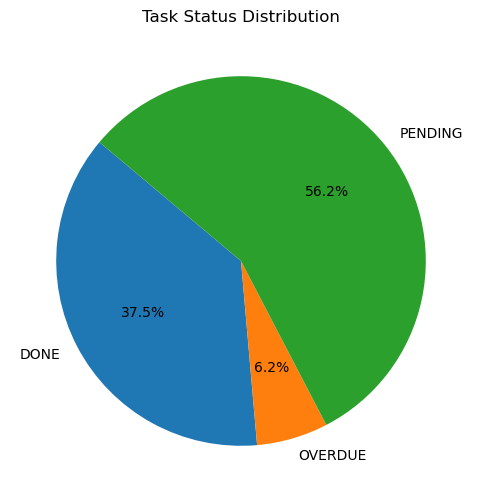

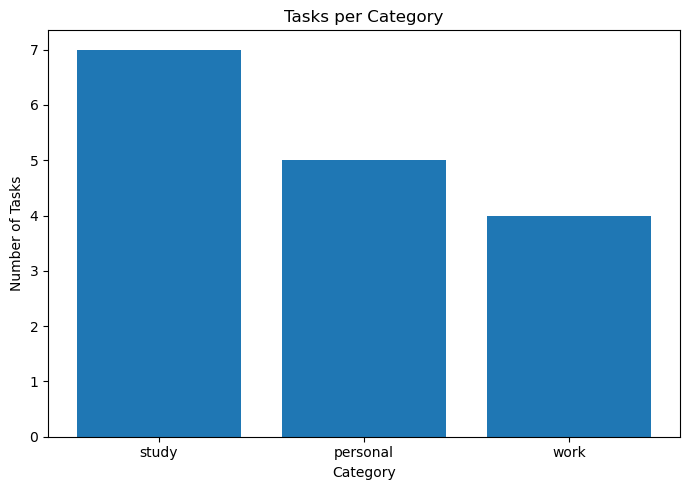

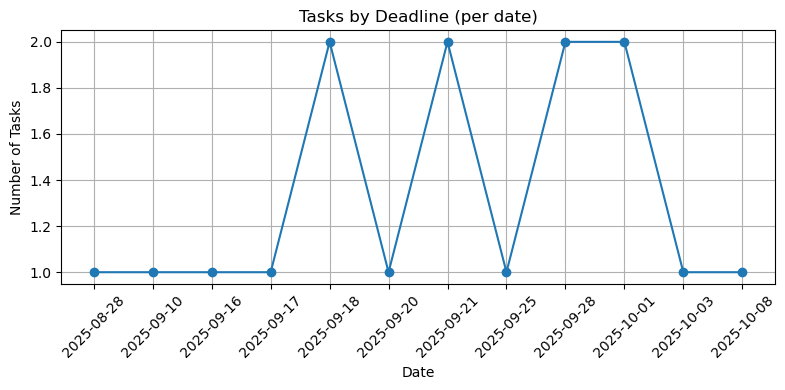

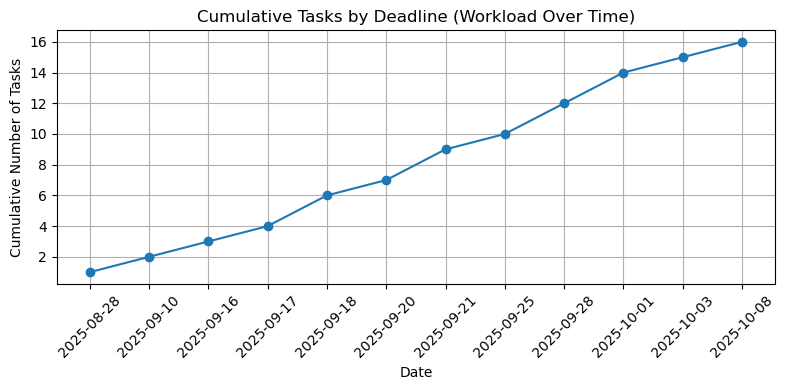

=====   Smart Task Tracker System   =====
1. Add Task
2. View All Tasks (sorted by deadline)
3. Search by Category
4. Mark Task as Done
5. Export Tasks to Excel
6. Visualize Tasks (pie, bar, line, cumulative)
7. Exit


Enter choice:  7


Goodbye!


In [12]:
def menu():
    while True:
        print(Fore.MAGENTA + "=====   Smart Task Tracker System   =====")
        print("1. Add Task")
        print("2. View All Tasks (sorted by deadline)")
        print("3. Search by Category")
        print("4. Mark Task as Done")
        print("5. Export Tasks to Excel")
        print("6. Visualize Tasks (pie, bar, line, cumulative)")
        print("7. Exit")
        choice = input("Enter choice: ").strip()
        if choice == "1":
            add_task()
        elif choice == "2":
            view_tasks()
        elif choice == "3":
            search_by_category()
        elif choice == "4":
            mark_done()
        elif choice == "5":
            export_to_excel()
        elif choice == "6":
            visualize_tasks()
        elif choice == "7":
            print(Fore.CYAN + "Goodbye!")
            break
        else:
            print(Fore.RED + "Invalid choice. Try again.\n")
if __name__ == "__main__":
    menu()

## THE END 

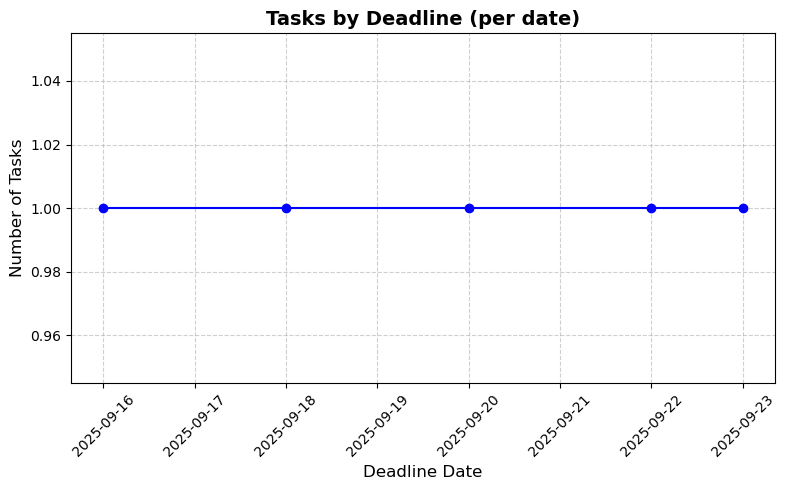

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Example task data
data = {
    "Title": ["Task1", "Task2", "Task3", "Task4", "Task5"],
    "Deadline": ["2025-09-16", "2025-09-18", "2025-09-20", "2025-09-22", "2025-09-23"]
}
df = pd.DataFrame(data)

# Convert Deadline to datetime
df["Deadline"] = pd.to_datetime(df["Deadline"])

# Count tasks per deadline date
task_counts = df.groupby("Deadline").size()

# Line Chart
plt.figure(figsize=(8,5))
plt.plot(task_counts.index, task_counts.values, marker='o', linestyle='-', color="blue")

# Customization
plt.title("Tasks by Deadline (per date)", fontsize=14, fontweight="bold")
plt.xlabel("Deadline Date", fontsize=12)
plt.ylabel("Number of Tasks", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

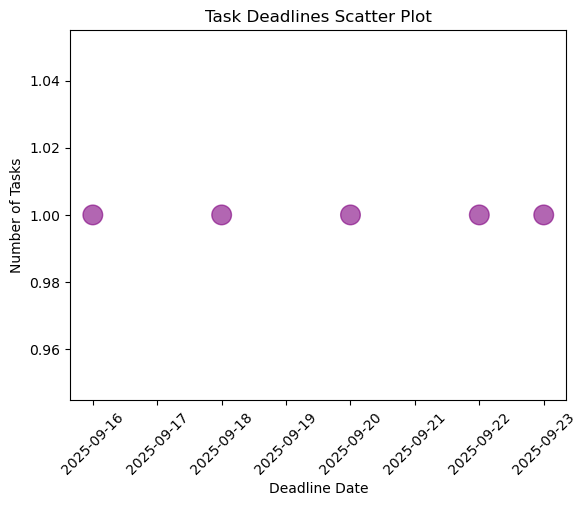

In [3]:
plt.scatter(task_counts.index, task_counts.values, s=task_counts.values*200, color="purple", alpha=0.6)
plt.title("Task Deadlines Scatter Plot")
plt.xlabel("Deadline Date")
plt.ylabel("Number of Tasks")
plt.xticks(rotation=45)
plt.show()
